In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, recall_score, roc_curve, precision_score, f1_score

In [85]:
consdf = pd.read_parquet('/uss/hdsi-prismdata/q2-ucsd-consDF.pqt')
consdf

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET
0,0,2021-09-01,726.0,0.0
1,1,2021-07-01,626.0,0.0
2,2,2021-05-01,680.0,0.0
3,3,2021-03-01,734.0,0.0
4,4,2021-10-01,676.0,0.0
...,...,...,...,...
14995,14995,2022-03-08,655.0,NaN
14996,14996,2022-01-15,625.0,NaN
14997,14997,2022-01-31,688.0,NaN
14998,14998,2022-03-08,722.0,NaN


In [86]:
acctdf = pd.read_parquet('/uss/hdsi-prismdata/q2-ucsd-acctDF.pqt')
acctdf

,prism_consumer_id,prism_account_id,account_type,balance_date,balance
0,3023,0,SAVINGS,2021-08-31,90.57
1,3023,1,CHECKING,2021-08-31,225.95
2,4416,2,SAVINGS,2022-03-31,15157.17
3,4416,3,CHECKING,2022-03-31,66.42
4,4227,4,CHECKING,2021-07-31,7042.90
...,...,...,...,...,...
24461,11500,24461,CHECKING,2022-03-27,732.75
24462,11615,24462,SAVINGS,2022-03-30,5.00
24463,11615,24463,CHECKING,2022-03-30,1956.46
24464,12210,24464,CHECKING,2022-03-28,2701.51


In [87]:
trxndf = pd.read_parquet('/uss/hdsi-prismdata/q2-ucsd-trxnDF.pqt')
trxndf

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,3023,0,4,0.05,CREDIT,2021-04-16
1,3023,1,12,481.56,CREDIT,2021-04-30
2,3023,2,4,0.05,CREDIT,2021-05-16
3,3023,3,4,0.07,CREDIT,2021-06-16
4,3023,4,4,0.06,CREDIT,2021-07-16
...,...,...,...,...,...,...
6407316,10533,6405304,31,4.96,DEBIT,2022-03-11
6407317,10533,6405305,12,63.48,DEBIT,2022-03-30
6407318,10533,6405306,12,53.99,DEBIT,2022-03-30
6407319,10533,6405307,12,175.98,DEBIT,2022-03-31


In [88]:
trxndf['prism_transaction_id'].nunique()

6405309

In [89]:
n_rows = len(trxndf)
n_unique = trxndf['prism_transaction_id'].nunique()
n_extra = n_rows - n_unique

print("rows:", n_rows)
print("unique prism_transaction_id:", n_unique)
print("extra rows due to duplicates:", n_extra)


rows: 6407321
unique prism_transaction_id: 6405309
extra rows due to duplicates: 2012


In [90]:
dup_counts = (
    trxndf['prism_transaction_id']
    .value_counts()
    .reset_index()
)

dup_counts.columns = ['prism_transaction_id', 'count']

dup_txn_ids = dup_counts[dup_counts['count'] > 1]
dup_txn_ids.head(20)


,prism_transaction_id,count
0,177178,2
1,665585,2
2,881321,2
3,881320,2
4,665573,2
5,665574,2
6,665575,2
7,665576,2
8,665577,2
9,665578,2


In [91]:
dup_rows = trxndf[
    trxndf['prism_transaction_id'].isin(dup_txn_ids['prism_transaction_id'])
].sort_values(['prism_transaction_id', 'posted_date'])

dup_rows


,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
1063155,4663,1062445,4,0.09,CREDIT,2021-08-16
1063156,4663,1062445,4,0.09,CREDIT,2021-08-16
1063157,4663,1062446,4,0.09,CREDIT,2021-09-16
1063158,4663,1062446,4,0.09,CREDIT,2021-09-16
1063159,4663,1062447,0,40.00,CREDIT,2021-09-21
...,...,...,...,...,...,...
964092,779,963384,0,60.00,DEBIT,2021-05-11
964093,779,963385,0,19.85,DEBIT,2021-05-18
964094,779,963385,0,19.85,DEBIT,2021-05-18
964095,779,963386,0,19.73,DEBIT,2021-05-18


In [92]:
trxndf = trxndf.drop_duplicates(
    subset=['prism_transaction_id'],
    keep='first'
)


## week 1 - feature importance

looking at how often balances get below $0 because it directly measures behavior and failures states 

In [46]:
acctdf['balance_date'] = pd.to_datetime(acctdf['balance_date'])


In [79]:
df = acctdf.merge(consdf, on='prism_consumer_id')
df

,prism_consumer_id,prism_account_id,account_type,balance_date,balance,evaluation_date,credit_score,DQ_TARGET
0,3023,0,SAVINGS,2021-08-31,90.57,2021-09-01,699.0,0.0
1,3023,1,CHECKING,2021-08-31,225.95,2021-09-01,699.0,0.0
2,4416,2,SAVINGS,2022-03-31,15157.17,2021-04-01,724.0,NaN
3,4416,3,CHECKING,2022-03-31,66.42,2021-04-01,724.0,NaN
4,4227,4,CHECKING,2021-07-31,7042.90,2021-08-01,707.0,NaN
...,...,...,...,...,...,...,...,...
24461,11500,24461,CHECKING,2022-03-27,732.75,2022-03-27,686.0,0.0
24462,11615,24462,SAVINGS,2022-03-30,5.00,2022-03-30,664.0,0.0
24463,11615,24463,CHECKING,2022-03-30,1956.46,2022-03-30,664.0,0.0
24464,12210,24464,CHECKING,2022-03-28,2701.51,2022-03-28,660.0,0.0


In [80]:
df['prism_consumer_id'].value_counts()

prism_consumer_id
14525    25
13491    14
14294    13
14679    12
5109     12
         ..
9449      1
8817      1
7551      1
7374      1
12210     1
Name: count, Length: 13009, dtype: int64

In [81]:
df['DQ_TARGET'].value_counts()

DQ_TARGET
0.0    17979
1.0     1508
Name: count, dtype: int64

In [82]:
DQ_0 = df[df['DQ_TARGET'] == 0.0]
DQ_0

,prism_consumer_id,prism_account_id,account_type,balance_date,balance,evaluation_date,credit_score,DQ_TARGET
0,3023,0,SAVINGS,2021-08-31,90.57,2021-09-01,699.0,0.0
1,3023,1,CHECKING,2021-08-31,225.95,2021-09-01,699.0,0.0
5,3920,5,SAVINGS,2021-10-31,0.26,2021-11-01,736.0,0.0
6,3920,6,CHECKING,2021-10-31,4.42,2021-11-01,736.0,0.0
7,3920,7,CHECKING,2021-10-31,1.05,2021-11-01,736.0,0.0
...,...,...,...,...,...,...,...,...
24461,11500,24461,CHECKING,2022-03-27,732.75,2022-03-27,686.0,0.0
24462,11615,24462,SAVINGS,2022-03-30,5.00,2022-03-30,664.0,0.0
24463,11615,24463,CHECKING,2022-03-30,1956.46,2022-03-30,664.0,0.0
24464,12210,24464,CHECKING,2022-03-28,2701.51,2022-03-28,660.0,0.0


In [83]:
DQ_1 = df[df['DQ_TARGET'] == 1.0 ]
DQ_1

,prism_consumer_id,prism_account_id,account_type,balance_date,balance,evaluation_date,credit_score,DQ_TARGET
29,196,29,SAVINGS,2021-08-27,18.86,2021-09-01,573.0,1.0
30,196,30,CHECKING,2021-11-30,1282.98,2021-09-01,573.0,1.0
55,3806,55,SAVINGS,2021-09-30,0.00,2021-10-01,680.0,1.0
56,3806,56,CHECKING,2021-09-30,4523.18,2021-10-01,680.0,1.0
239,2162,239,SAVINGS,2021-02-28,193.25,2021-03-01,665.0,1.0
...,...,...,...,...,...,...,...,...
24230,12880,24230,SAVINGS,2022-03-27,8044.50,2022-03-27,664.0,1.0
24233,12880,24233,CHECKING,2022-03-27,491.59,2022-03-27,664.0,1.0
24399,12162,24399,CHECKING,2021-12-09,154.58,2021-12-09,654.0,1.0
24424,12162,24424,CHECKING,2021-12-09,126.27,2021-12-09,654.0,1.0


In [84]:
DQ_1['credit_score'].mean()

593.8415119363395

In [85]:
df['credit_score'].mean()

665.3855963377749

In [86]:
df['balance'].mean()

4296.199248753373

In [87]:
DQ_1['balance'].mean()

1284.024675066313

In [88]:
df[df['balance'] < 0]

,prism_consumer_id,prism_account_id,account_type,balance_date,balance,evaluation_date,credit_score,DQ_TARGET
82,2246,82,CHECKING,2021-04-30,-168.90,2021-05-01,703.0,0.0
206,2751,206,CHECKING,2022-03-30,-474.41,2022-04-01,677.0,0.0
506,2242,506,CHECKING,2022-03-31,-49.52,2022-02-01,662.0,0.0
616,3280,616,CHECKING,2021-11-30,-7.23,2021-12-01,680.0,0.0
904,1056,904,CHECKING,2021-03-31,-313.61,2021-04-01,655.0,0.0
...,...,...,...,...,...,...,...,...
24239,12997,24239,CREDIT CARD,2021-12-14,-25.00,2021-12-14,695.0,0.0
24279,13976,24279,CREDIT CARD,2022-02-15,-1025.27,2022-02-15,806.0,0.0
24296,11678,24296,CHECKING,2021-12-19,-145.00,2021-12-19,657.0,0.0
24357,10353,24357,SAVINGS,2021-12-16,-10.00,2021-12-16,685.0,0.0


### bottom 10th percentile

creating a feature using the bottom 10th percentile of their balances to get a sense of how low their balances get

In [89]:
balance_p10 = (
    df.groupby('prism_consumer_id')['balance']
      .quantile(0.10)
      .reset_index()
      .rename(columns={'balance': 'balance_p10'})
)
balance_p10

,prism_consumer_id,balance_p10
0,0,52.597
1,1,403.234
2,10,83.616
3,100,907.467
4,1000,9.541
...,...,...
13004,9995,0.000
13005,9996,252.670
13006,9997,611.280
13007,9998,-862.990


In [90]:
dq_labels = (df[['prism_consumer_id', 'DQ_TARGET']].drop_duplicates())

In [91]:
model_df = balance_p10.merge(dq_labels, on='prism_consumer_id', how='inner')
model_df = model_df.dropna(subset=['DQ_TARGET'])
model_df

,prism_consumer_id,balance_p10,DQ_TARGET
0,0,52.597,0.0
1,1,403.234,0.0
2,10,83.616,0.0
3,100,907.467,0.0
4,1000,9.541,0.0
...,...,...,...
12956,995,22142.967,0.0
12966,996,0.000,0.0
12977,997,11732.731,0.0
12987,998,1340.621,0.0


In [92]:
# model_df[model_df['balance_p10'] < 0]

- logistic regression maps features to a probability of being 1
- ROC-AUC measures how well those probabilities separate 0s from 1s

here, a low balance indicates a higher risk so we need to take the negative because logistic regression assumes that higher values of X increase probability of positive class but it's inverted
- higher X --> higher predicted probability of DQ=1

In [93]:
X = -model_df[['balance_p10']]
y = model_df['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

model = LogisticRegression()
model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:, 1]

# lowered threshold bc of class imbalance
y_pred = (y_prob >= 0.1).astype(int)

auc = roc_auc_score(y_test, y_prob)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"ROC-AUC: {auc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall (DQ=1): {recall:.3f}")
print(f"F1-score: {f1:.3f}")


ROC-AUC: 0.703
Precision: 0.132
Recall (DQ=1): 0.796
F1-score: 0.227


**roc-auc**:  if you take one person who became delinquent and one who didn’t, the model will correctly rank the delinquent person as riskier about 7 out of 10 times

**precision**: of all the accounts that the model predicted as DQ=1, only 13% were actually delinquent

**recall**: of all the actual delinquent accounts, the model correctly identified about 80%

**f1-score**: while the model catches most positives, many predicted positives are actually false

bad because catching most DQ=1 accounts at the expense of predicting a lot of false positives

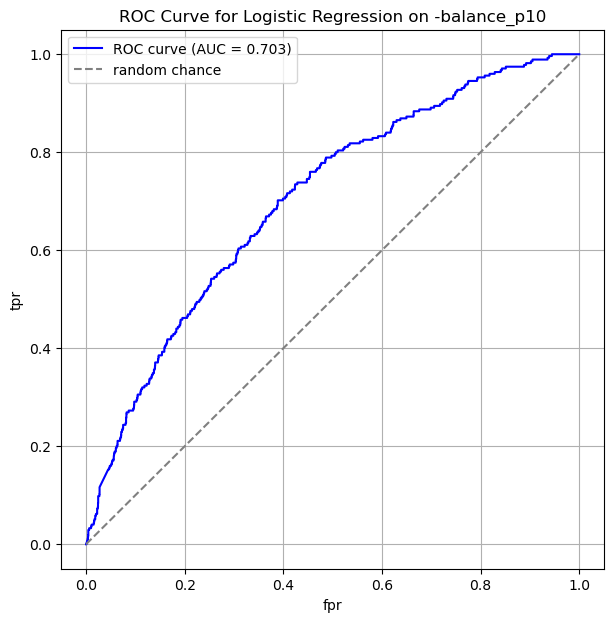

In [94]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='random chance')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve for Logistic Regression on -balance_p10')
plt.legend()
plt.grid(True)
plt.show()

In [95]:
y_prob.min(), y_prob.max()


(2.91104262774011e-46, 0.42354919347848785)

even the riskiest person I can find only has about a 23% chance of being delinquent
this means that: 
1. deliquency is rare (1508 versus 17979)
2. only using one feature (if we had more features it would be more accurate at correctly predicitng)
3. this model is better at ranking than classification (yes/no decisions)

but roc-auc is still helpful because riskier people still get higher scores than safer people

In [96]:
threshold = np.percentile(y_prob, 90)  # top 10%
y_pred_top10 = (y_prob >= threshold).astype(int)

recall_top10 = recall_score(y_test, y_pred_top10)
print(f"Recall in top 10% risk: {recall_top10:.3f}")


Recall in top 10% risk: 0.269


if we take the 10% riskiest users according to the model, we correctly catch 31.3% of all bad users, which is about 3x better than random even though there is heavy class imbalance

**literally just average balance**

In [97]:
balance_mean = (
    df.groupby('prism_consumer_id')['balance']
      .mean()
      .reset_index()
      .rename(columns={'balance': 'balance_mean'})
)

mean_df = balance_mean.merge(dq_labels, on='prism_consumer_id')

mean_df = mean_df.dropna(subset=['DQ_TARGET'])

X = -mean_df[['balance_mean']]
y = mean_df['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

model.fit(X_train, y_train)
y_prob = model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_prob)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"ROC-AUC: {auc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall (DQ=1): {recall:.3f}")
print(f"F1-score: {f1:.3f}")



ROC-AUC: 0.717
Precision: 0.132
Recall (DQ=1): 0.796
F1-score: 0.227


**roc-auc**: if you take one person who became delinquent and one who didn’t, the model will correctly rank the delinquent person as riskier about 7 out of 10 times (0.717)

**precision**: of all the accounts that the model predicted as DQ=1, only 13% were actually delinquent (0.132)

**recall**: of all the actual delinquent accounts, the model correctly identified about 80% (0.796)

**f1-score**: while the model catches most positives, many predicted positives are actually false (0.227)

using mean balance as a feature is good at catching most DQ=1 accounts, but it also predicts a lot of false positives

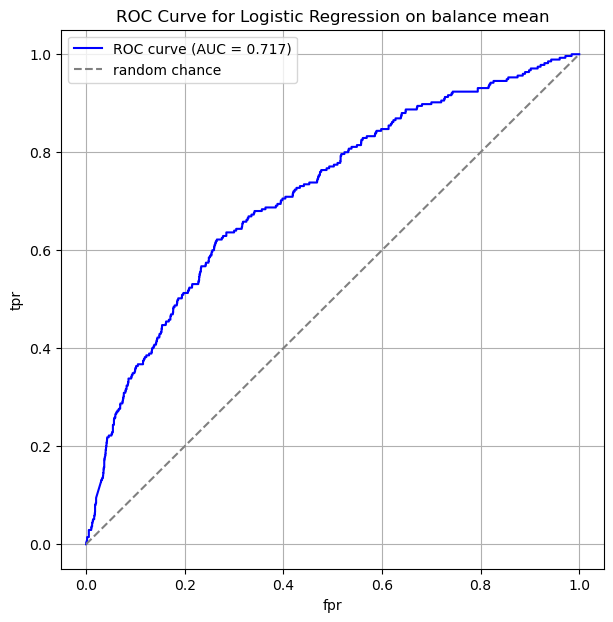

In [98]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='random chance')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve for Logistic Regression on balance mean')
plt.legend()
plt.grid(True)
plt.show()

### new flow = total credits - total debits

or **average net flow**=net flow / number of months over a periiod

In [99]:
cons_acct = pd.merge(consdf, acctdf, on='prism_consumer_id', how='left')
full_df = pd.merge(trxndf, cons_acct, on='prism_consumer_id', how='left')
print(full_df.shape)
full_df.head()


(12828110, 13)


,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date,evaluation_date,credit_score,DQ_TARGET,prism_account_id,account_type,balance_date,balance
0,3023,0,4,0.05,CREDIT,2021-04-16,2021-09-01,699.0,0.0,0,SAVINGS,2021-08-31,90.57
1,3023,0,4,0.05,CREDIT,2021-04-16,2021-09-01,699.0,0.0,1,CHECKING,2021-08-31,225.95
2,3023,1,12,481.56,CREDIT,2021-04-30,2021-09-01,699.0,0.0,0,SAVINGS,2021-08-31,90.57
3,3023,1,12,481.56,CREDIT,2021-04-30,2021-09-01,699.0,0.0,1,CHECKING,2021-08-31,225.95
4,3023,2,4,0.05,CREDIT,2021-05-16,2021-09-01,699.0,0.0,0,SAVINGS,2021-08-31,90.57


In [100]:
full_df['posted_date'] = pd.to_datetime(full_df['posted_date'])

net_flow_df = full_df.groupby('prism_consumer_id').apply(
    lambda x: pd.Series({
        'total_credit': x.loc[x['credit_or_debit'] == 'CREDIT', 'amount'].sum(),
        'total_debit': x.loc[x['credit_or_debit'] == 'DEBIT', 'amount'].sum(),
        'first_date': x['posted_date'].min(),
        'last_date': x['posted_date'].max()
    })
).reset_index()

net_flow_df['net_flow'] = net_flow_df['total_credit'] - net_flow_df['total_debit']
net_flow_df['months_active'] = ((net_flow_df['last_date'] - net_flow_df['first_date']).dt.days / 30).apply(lambda x: max(x, 1))
net_flow_df['avg_net_flow'] = net_flow_df['net_flow'] / net_flow_df['months_active']

full_df = pd.merge(full_df, net_flow_df[['prism_consumer_id', 'net_flow', 'avg_net_flow']], 
                   on='prism_consumer_id', how='left')

full_df = full_df.dropna(subset=['DQ_TARGET'])


full_df[['prism_consumer_id', 'net_flow', 'avg_net_flow', 'DQ_TARGET']].drop_duplicates().head()


/tmp/ipykernel_295/3257707724.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  net_flow_df = full_df.groupby('prism_consumer_id').apply(


,prism_consumer_id,net_flow,avg_net_flow,DQ_TARGET
0,3023,1320.08,220.013333,0.0
1008,3920,-592.53,-99.306704,0.0
1624,318,-67946.32,-11324.386667,0.0
2726,3856,-676.06,-131.700000,0.0
2758,341,293.88,48.980000,0.0


**net flows**

In [101]:
X = full_df[['prism_consumer_id', 'net_flow']].drop_duplicates()[['net_flow']]
y = full_df[['prism_consumer_id', 'DQ_TARGET']].drop_duplicates()['DQ_TARGET']  # target column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [102]:
net_flow_df = full_df[['prism_consumer_id', 'net_flow']].drop_duplicates()
dq_df = full_df[['prism_consumer_id', 'DQ_TARGET']].drop_duplicates()
model_df = net_flow_df.merge(dq_df, on='prism_consumer_id', how='inner')

X = model_df[['net_flow']]
y = model_df['DQ_TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]

In [103]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"roc-auc: {roc_auc:.3f}")

roc-auc: 0.566


In [104]:
# precision, recall, F1 at a lowered threshold because all were 0 at 0.5, 0.2
y_pred = (y_pred_proba >= 0.1).astype(int)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

Precision: 0.095
Recall: 0.007
F1-score: 0.013


**roc-auc**: if you take one person who became delinquent and one who didn’t, the model will correctly rank the delinquent person as riskier about 57 out of 100 times (0.566)

**precision**: of all the accounts that the model predicted as DQ=1, only 9.5% were actually delinquent (0.095)

**recall**: of all the actual delinquent accounts, the model correctly identified less than 1% (0.007)

**f1-score**: while the model catches very few positives, most predicted positives are false (0.013)

using net_flow as a feature is very weak at predicting delinquency, with almost no ability to identify actual DQ=1 accounts

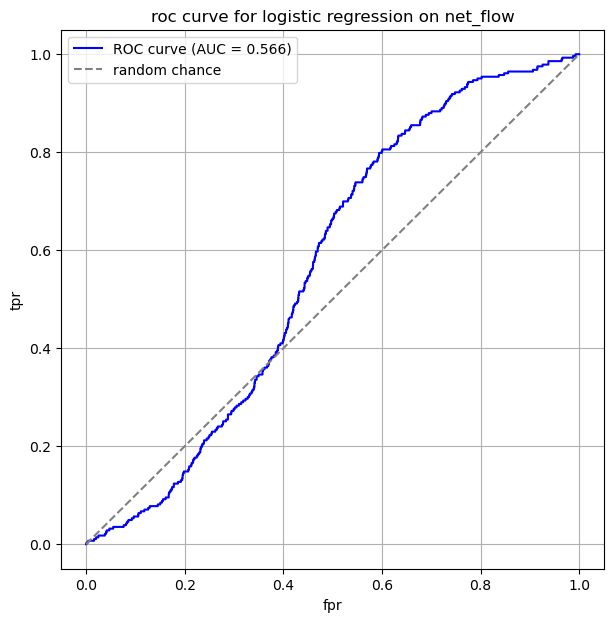

In [105]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)


plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='random chance')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('roc curve for logistic regression on net_flow')
plt.legend()
plt.grid(True)
plt.show()

histogram + KDE plot

<Axes: xlabel='net_flow', ylabel='Count'>

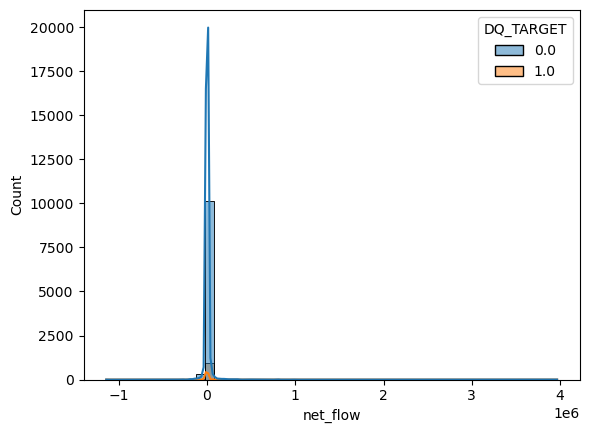

In [106]:
sns.histplot(data=model_df, x='net_flow', hue='DQ_TARGET', bins=50, kde=True)


**average net flows**

In [107]:
X = full_df[['prism_consumer_id', 'avg_net_flow']].drop_duplicates()[['avg_net_flow']]
y = full_df[['prism_consumer_id', 'DQ_TARGET']].drop_duplicates()['DQ_TARGET']  # target column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [108]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # probability of positive class


In [109]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC for avg net flow:", roc_auc)


ROC-AUC for avg net flow: 0.5602783983806133


In [110]:
y_pred = (y_pred_proba >= 0.1).astype(int)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

Precision: 0.091
Recall: 0.007
F1-score: 0.013


**roc-auc**: if you take one person who became delinquent and one who didn’t, the model will correctly rank the delinquent person as riskier about 56 out of 100 times (0.560)

**precision**: of all the accounts that the model predicted as DQ=1, only 9.1% were actually delinquent (0.091)

**recall**: of all the actual delinquent accounts, the model correctly identified less than 1% (0.007)

**f1-score**: while the model catches very few positives, most predicted positives are false (0.013)

using avg_net_flow as a feature is very weak at predicting delinquency, with almost no ability to identify actual DQ=1 accounts.

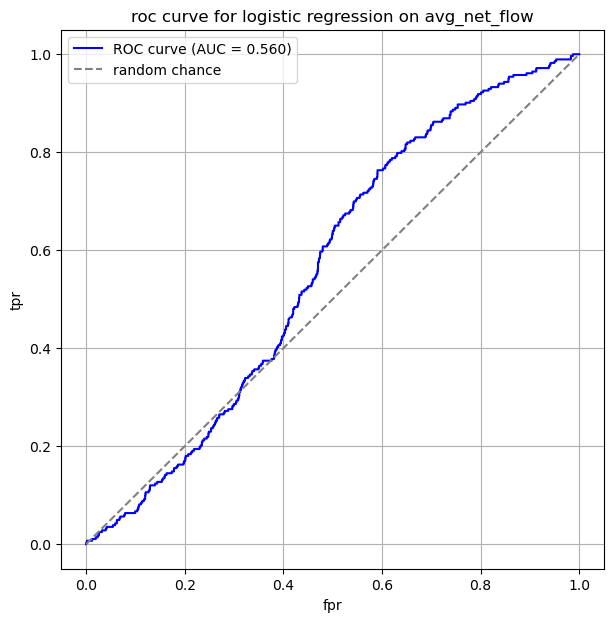

In [111]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(7,7))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='random chance')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('roc curve for logistic regression on avg_net_flow')
plt.legend()
plt.grid(True)
plt.show()

## week 2: balance and income related features

In [112]:
full_df.head()

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date,evaluation_date,credit_score,DQ_TARGET,prism_account_id,account_type,balance_date,balance,net_flow,avg_net_flow
0,3023,0,4,0.05,CREDIT,2021-04-16,2021-09-01,699.0,0.0,0,SAVINGS,2021-08-31,90.57,1320.08,220.013333
1,3023,0,4,0.05,CREDIT,2021-04-16,2021-09-01,699.0,0.0,1,CHECKING,2021-08-31,225.95,1320.08,220.013333
2,3023,1,12,481.56,CREDIT,2021-04-30,2021-09-01,699.0,0.0,0,SAVINGS,2021-08-31,90.57,1320.08,220.013333
3,3023,1,12,481.56,CREDIT,2021-04-30,2021-09-01,699.0,0.0,1,CHECKING,2021-08-31,225.95,1320.08,220.013333
4,3023,2,4,0.05,CREDIT,2021-05-16,2021-09-01,699.0,0.0,0,SAVINGS,2021-08-31,90.57,1320.08,220.013333


In [161]:
tx_df = (
    full_df
    .sort_values("posted_date")
    .drop_duplicates(
        subset=["prism_consumer_id", "prism_transaction_id"],
        keep="first"
    )
    .copy()
)


In [162]:
tx_df["posted_date"] = pd.to_datetime(tx_df["posted_date"])

tx_df["signed_amount"] = tx_df["amount"].where(
    tx_df["credit_or_debit"] == "CREDIT",
    -tx_df["amount"]
)


In [163]:
tx_df = tx_df.sort_values(
    ["prism_consumer_id", "posted_date"]
)

tx_df["running_balance"] = (
    tx_df
    .groupby("prism_consumer_id")["signed_amount"]
    .cumsum()
)


In [164]:
starting_balances = (
    full_df
    .groupby("prism_consumer_id")["balance"]
    .first()
)

tx_df["running_balance"] += tx_df["prism_consumer_id"].map(starting_balances)


In [165]:
# restricted to 2021 transactions to have a better visualization
tx_df["posted_date"] = pd.to_datetime(tx_df["posted_date"])

tx_2021 = tx_df[tx_df["posted_date"].dt.year == 2021].copy()


In [166]:
tx_2021["signed_amount"] = tx_2021["amount"].where(
    tx_2021["credit_or_debit"] == "CREDIT",
    -tx_2021["amount"]
)


In [167]:
eligible_ids = (
    tx_2021
    .groupby("prism_consumer_id")
    .size()
    .loc[lambda x: x > 5]   # at least 5 transactions
    .index
)

In [172]:
good_ids = (
    tx_2021[
        (tx_2021["DQ_TARGET"] == 0) &
        (tx_2021["prism_consumer_id"].isin(eligible_ids))
    ]["prism_consumer_id"]
    .drop_duplicates()
    .sample(5)
)

bad_ids = (
    tx_2021[
        (tx_2021["DQ_TARGET"] == 1) &
        (tx_2021["prism_consumer_id"].isin(eligible_ids))
    ]["prism_consumer_id"]
    .drop_duplicates()
    .sample(5)
)

sample_ids = list(good_ids) + list(bad_ids)


In [173]:
sample_df = tx_2021[
    tx_2021["prism_consumer_id"].isin(sample_ids)
].copy()

sample_df = sample_df.sort_values(
    ["prism_consumer_id", "posted_date"]
)

sample_df["running_balance"] = (
    sample_df
    .groupby("prism_consumer_id")["signed_amount"]
    .cumsum()
)


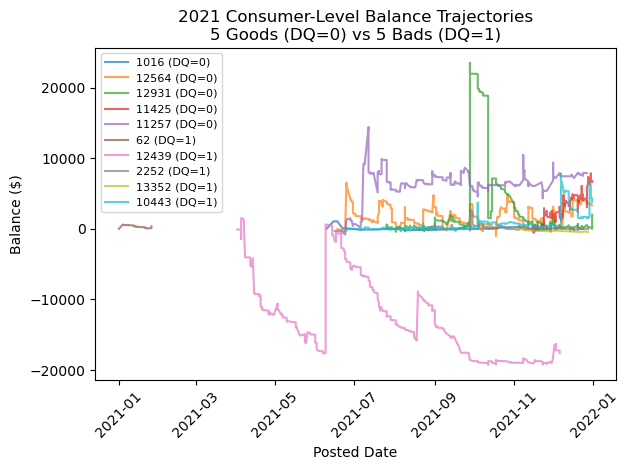

In [174]:
import matplotlib.pyplot as plt

plt.figure()

for cid in sample_ids:
    df_c = sample_df[sample_df["prism_consumer_id"] == cid]
    dq = int(df_c["DQ_TARGET"].iloc[0])
    label = f"{cid} (DQ={dq})"
    plt.plot(df_c["posted_date"], df_c["running_balance"], alpha=0.7, label=label)

plt.xlabel("Posted Date")
plt.ylabel("Balance ($)")
plt.title("2021 Consumer-Level Balance Trajectories\n5 Goods (DQ=0) vs 5 Bads (DQ=1)")
plt.xticks(rotation=45)
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


In [175]:
import numpy as np
import matplotlib.pyplot as plt

def plot_goods_vs_bads(tx_df, full_df, year=2021, n=5, seed=42, min_txns=5):
    np.random.seed(seed)

    # Restrict to year
    df = tx_df[tx_df["posted_date"].dt.year == year].copy()

    # Signed amounts
    df["signed_amount"] = df["amount"].where(
        df["credit_or_debit"] == "CREDIT",
        -df["amount"]
    )

    # Eligible consumers (enough transactions)
    eligible_ids = (
        df.groupby("prism_consumer_id")
        .size()
        .loc[lambda x: x >= min_txns]
        .index
    )

    # Sample goods & bads
    good_ids = (
        df[
            (df["DQ_TARGET"] == 0) &
            (df["prism_consumer_id"].isin(eligible_ids))
        ]["prism_consumer_id"]
        .drop_duplicates()
        .sample(n)
    )

    bad_ids = (
        df[
            (df["DQ_TARGET"] == 1) &
            (df["prism_consumer_id"].isin(eligible_ids))
        ]["prism_consumer_id"]
        .drop_duplicates()
        .sample(n)
    )

    sample_ids = list(good_ids) + list(bad_ids)

    # Compute running balance
    plot_df = df[df["prism_consumer_id"].isin(sample_ids)].copy()
    plot_df = plot_df.sort_values(["prism_consumer_id", "posted_date"])

    plot_df["running_balance"] = (
        plot_df
        .groupby("prism_consumer_id")["signed_amount"]
        .cumsum()
    )

    # Optional anchor
    starting_balances = (
        full_df
        .groupby("prism_consumer_id")["balance"]
        .first()
    )
    plot_df["running_balance"] += plot_df["prism_consumer_id"].map(starting_balances)

    # Plot
    plt.figure()
    for cid in sample_ids:
        df_c = plot_df[plot_df["prism_consumer_id"] == cid]
        dq = int(df_c["DQ_TARGET"].iloc[0])
        plt.plot(
            df_c["posted_date"],
            df_c["running_balance"],
            alpha=0.7,
            label=f"{cid} (DQ={dq})"
        )

    plt.xlabel("Posted Date")
    plt.ylabel("Balance ($)")
    plt.title(f"{year} Balance Trajectories: {n} Goods vs {n} Bads (seed={seed})")
    plt.legend(fontsize=8)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


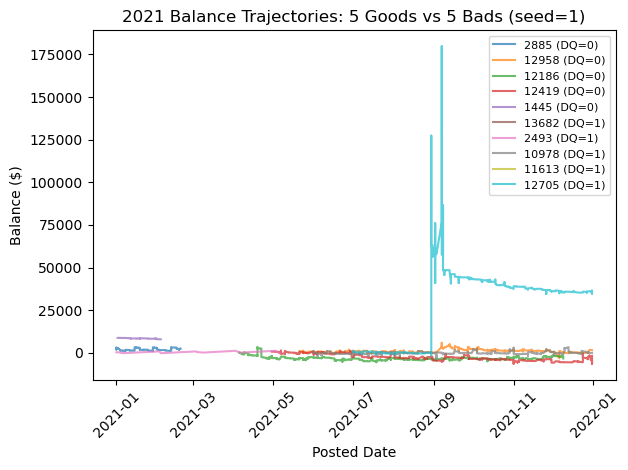

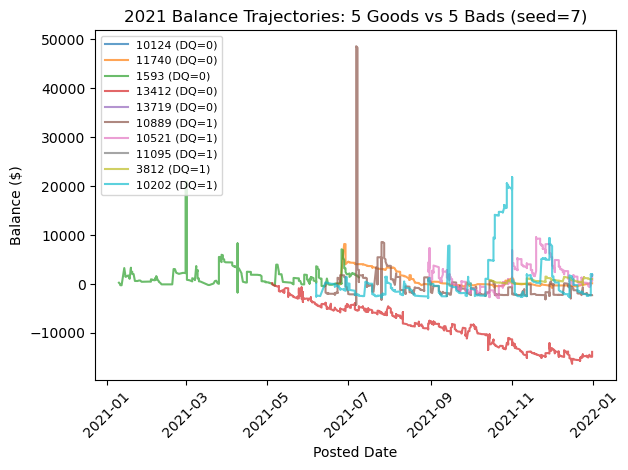

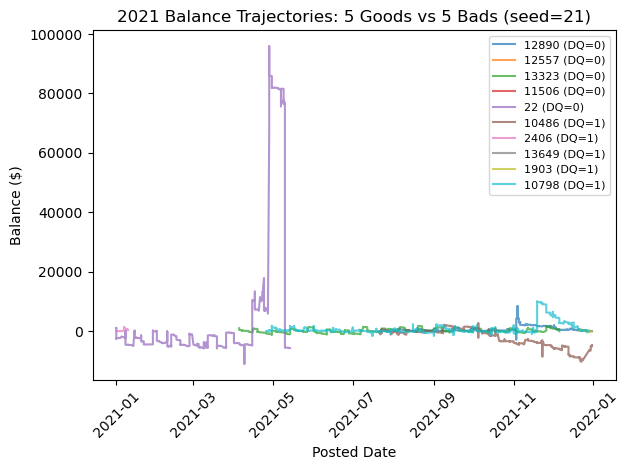

In [176]:
plot_goods_vs_bads(tx_df, full_df, seed=1)
plot_goods_vs_bads(tx_df, full_df, seed=7)
plot_goods_vs_bads(tx_df, full_df, seed=21)


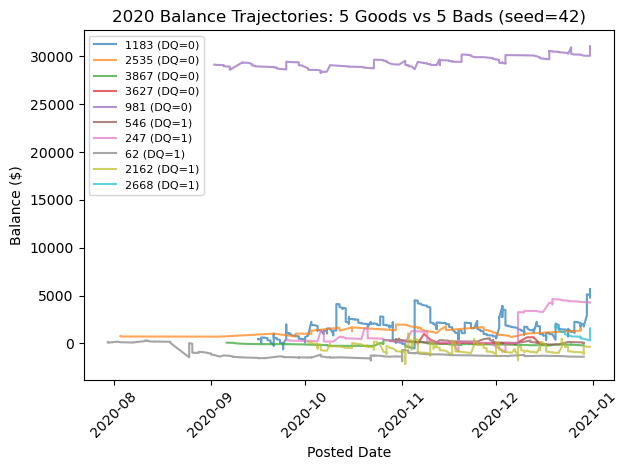

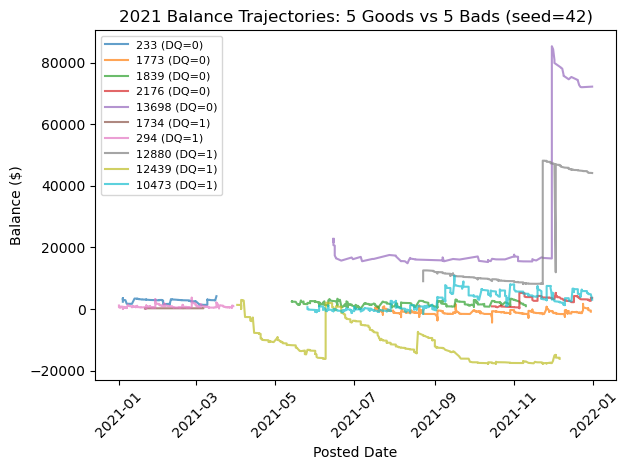

In [177]:
plot_goods_vs_bads(tx_df, full_df, year=2020)
plot_goods_vs_bads(tx_df, full_df, year=2021)

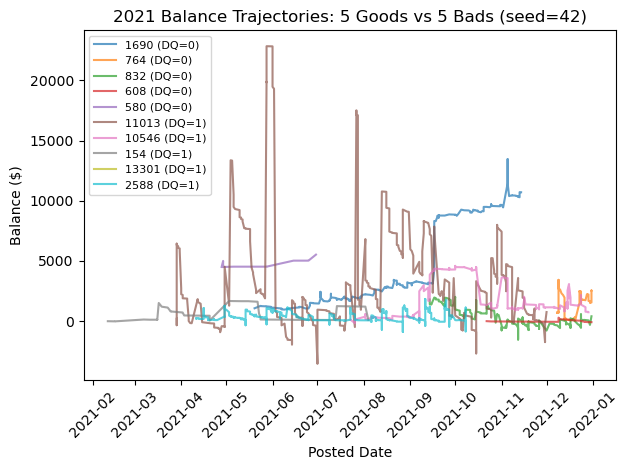

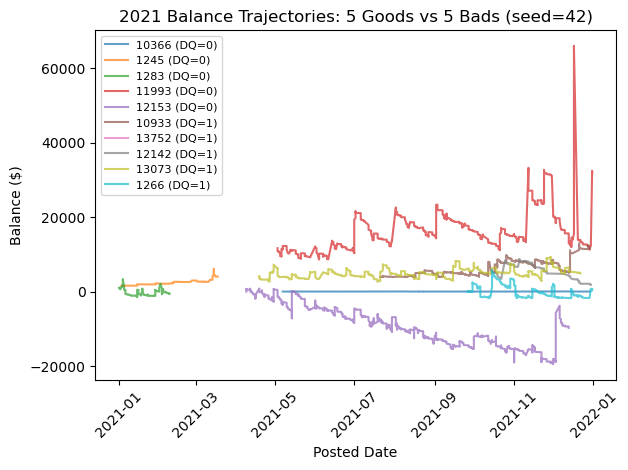

In [178]:
plot_goods_vs_bads(tx_df, full_df, min_txns=10)
plot_goods_vs_bads(tx_df, full_df, min_txns=20)


In [113]:
cons_3023 = full_df[full_df['prism_consumer_id'] == '3023']
cons_3023

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date,evaluation_date,credit_score,DQ_TARGET,prism_account_id,account_type,balance_date,balance,net_flow,avg_net_flow
0,3023,0,4,0.05,CREDIT,2021-04-16,2021-09-01,699.0,0.0,0,SAVINGS,2021-08-31,90.57,1320.08,220.013333
1,3023,0,4,0.05,CREDIT,2021-04-16,2021-09-01,699.0,0.0,1,CHECKING,2021-08-31,225.95,1320.08,220.013333
2,3023,1,12,481.56,CREDIT,2021-04-30,2021-09-01,699.0,0.0,0,SAVINGS,2021-08-31,90.57,1320.08,220.013333
3,3023,1,12,481.56,CREDIT,2021-04-30,2021-09-01,699.0,0.0,1,CHECKING,2021-08-31,225.95,1320.08,220.013333
4,3023,2,4,0.05,CREDIT,2021-05-16,2021-09-01,699.0,0.0,0,SAVINGS,2021-08-31,90.57,1320.08,220.013333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,3023,202,16,21.85,DEBIT,2021-09-20,2021-09-01,699.0,0.0,1,CHECKING,2021-08-31,225.95,1320.08,220.013333
406,3023,203,45,25.00,DEBIT,2021-09-20,2021-09-01,699.0,0.0,0,SAVINGS,2021-08-31,90.57,1320.08,220.013333
407,3023,203,45,25.00,DEBIT,2021-09-20,2021-09-01,699.0,0.0,1,CHECKING,2021-08-31,225.95,1320.08,220.013333
408,3023,204,45,200.00,DEBIT,2021-09-20,2021-09-01,699.0,0.0,0,SAVINGS,2021-08-31,90.57,1320.08,220.013333


In [114]:
cons_3023['posted_date'].unique()

<DatetimeArray>
['2021-04-16 00:00:00', '2021-04-30 00:00:00', '2021-05-16 00:00:00',
 '2021-06-16 00:00:00', '2021-07-16 00:00:00', '2021-08-16 00:00:00',
 '2021-09-16 00:00:00', '2021-03-27 00:00:00', '2021-04-02 00:00:00',
 '2021-04-06 00:00:00',
 ...
 '2021-08-31 00:00:00', '2021-09-02 00:00:00', '2021-09-07 00:00:00',
 '2021-09-08 00:00:00', '2021-09-10 00:00:00', '2021-09-13 00:00:00',
 '2021-09-14 00:00:00', '2021-09-15 00:00:00', '2021-09-18 00:00:00',
 '2021-09-20 00:00:00']
Length: 109, dtype: datetime64[ns]

In [115]:
cons_3023 = cons_3023.sort_values(['posted_date'], ascending=True)
cons_3023

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date,evaluation_date,credit_score,DQ_TARGET,prism_account_id,account_type,balance_date,balance,net_flow,avg_net_flow
93,3023,46,20,20.63,DEBIT,2021-03-24,2021-09-01,699.0,0.0,1,CHECKING,2021-08-31,225.95,1320.08,220.013333
92,3023,46,20,20.63,DEBIT,2021-03-24,2021-09-01,699.0,0.0,0,SAVINGS,2021-08-31,90.57,1320.08,220.013333
17,3023,8,1,340.00,CREDIT,2021-03-27,2021-09-01,699.0,0.0,1,CHECKING,2021-08-31,225.95,1320.08,220.013333
16,3023,8,1,340.00,CREDIT,2021-03-27,2021-09-01,699.0,0.0,0,SAVINGS,2021-08-31,90.57,1320.08,220.013333
15,3023,7,1,240.00,CREDIT,2021-03-27,2021-09-01,699.0,0.0,1,CHECKING,2021-08-31,225.95,1320.08,220.013333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,3023,203,45,25.00,DEBIT,2021-09-20,2021-09-01,699.0,0.0,0,SAVINGS,2021-08-31,90.57,1320.08,220.013333
408,3023,204,45,200.00,DEBIT,2021-09-20,2021-09-01,699.0,0.0,0,SAVINGS,2021-08-31,90.57,1320.08,220.013333
404,3023,202,16,21.85,DEBIT,2021-09-20,2021-09-01,699.0,0.0,0,SAVINGS,2021-08-31,90.57,1320.08,220.013333
405,3023,202,16,21.85,DEBIT,2021-09-20,2021-09-01,699.0,0.0,1,CHECKING,2021-08-31,225.95,1320.08,220.013333


In [116]:
# checking for logic to see that there are more entries of spending than income 
cons_3023['credit_or_debit'].value_counts()

credit_or_debit
DEBIT     328
CREDIT     82
Name: count, dtype: int64

In [117]:
cons_3023["signed_amount"] = cons_3023["amount"].where(
    cons_3023["credit_or_debit"] == "CREDIT",
    -cons_3023["amount"]
)

In [118]:
# cons_3023['amount'].unique()

In [119]:
cons_3023 = cons_3023.sort_values("posted_date")
cons_3023

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date,evaluation_date,credit_score,DQ_TARGET,prism_account_id,account_type,balance_date,balance,net_flow,avg_net_flow,signed_amount
93,3023,46,20,20.63,DEBIT,2021-03-24,2021-09-01,699.0,0.0,1,CHECKING,2021-08-31,225.95,1320.08,220.013333,-20.63
92,3023,46,20,20.63,DEBIT,2021-03-24,2021-09-01,699.0,0.0,0,SAVINGS,2021-08-31,90.57,1320.08,220.013333,-20.63
17,3023,8,1,340.00,CREDIT,2021-03-27,2021-09-01,699.0,0.0,1,CHECKING,2021-08-31,225.95,1320.08,220.013333,340.00
16,3023,8,1,340.00,CREDIT,2021-03-27,2021-09-01,699.0,0.0,0,SAVINGS,2021-08-31,90.57,1320.08,220.013333,340.00
15,3023,7,1,240.00,CREDIT,2021-03-27,2021-09-01,699.0,0.0,1,CHECKING,2021-08-31,225.95,1320.08,220.013333,240.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,3023,204,45,200.00,DEBIT,2021-09-20,2021-09-01,699.0,0.0,0,SAVINGS,2021-08-31,90.57,1320.08,220.013333,-200.00
405,3023,202,16,21.85,DEBIT,2021-09-20,2021-09-01,699.0,0.0,1,CHECKING,2021-08-31,225.95,1320.08,220.013333,-21.85
407,3023,203,45,25.00,DEBIT,2021-09-20,2021-09-01,699.0,0.0,1,CHECKING,2021-08-31,225.95,1320.08,220.013333,-25.00
406,3023,203,45,25.00,DEBIT,2021-09-20,2021-09-01,699.0,0.0,0,SAVINGS,2021-08-31,90.57,1320.08,220.013333,-25.00


In [120]:
starting_balance = cons_3023["balance"].iloc[0]

cons_3023["running_balance"] = cons_3023["signed_amount"].cumsum() + starting_balance
cons_3023

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date,evaluation_date,credit_score,DQ_TARGET,prism_account_id,account_type,balance_date,balance,net_flow,avg_net_flow,signed_amount,running_balance
93,3023,46,20,20.63,DEBIT,2021-03-24,2021-09-01,699.0,0.0,1,CHECKING,2021-08-31,225.95,1320.08,220.013333,-20.63,205.32
92,3023,46,20,20.63,DEBIT,2021-03-24,2021-09-01,699.0,0.0,0,SAVINGS,2021-08-31,90.57,1320.08,220.013333,-20.63,184.69
17,3023,8,1,340.00,CREDIT,2021-03-27,2021-09-01,699.0,0.0,1,CHECKING,2021-08-31,225.95,1320.08,220.013333,340.00,524.69
16,3023,8,1,340.00,CREDIT,2021-03-27,2021-09-01,699.0,0.0,0,SAVINGS,2021-08-31,90.57,1320.08,220.013333,340.00,864.69
15,3023,7,1,240.00,CREDIT,2021-03-27,2021-09-01,699.0,0.0,1,CHECKING,2021-08-31,225.95,1320.08,220.013333,240.00,1104.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,3023,204,45,200.00,DEBIT,2021-09-20,2021-09-01,699.0,0.0,0,SAVINGS,2021-08-31,90.57,1320.08,220.013333,-200.00,1817.88
405,3023,202,16,21.85,DEBIT,2021-09-20,2021-09-01,699.0,0.0,1,CHECKING,2021-08-31,225.95,1320.08,220.013333,-21.85,1796.03
407,3023,203,45,25.00,DEBIT,2021-09-20,2021-09-01,699.0,0.0,1,CHECKING,2021-08-31,225.95,1320.08,220.013333,-25.00,1771.03
406,3023,203,45,25.00,DEBIT,2021-09-20,2021-09-01,699.0,0.0,0,SAVINGS,2021-08-31,90.57,1320.08,220.013333,-25.00,1746.03


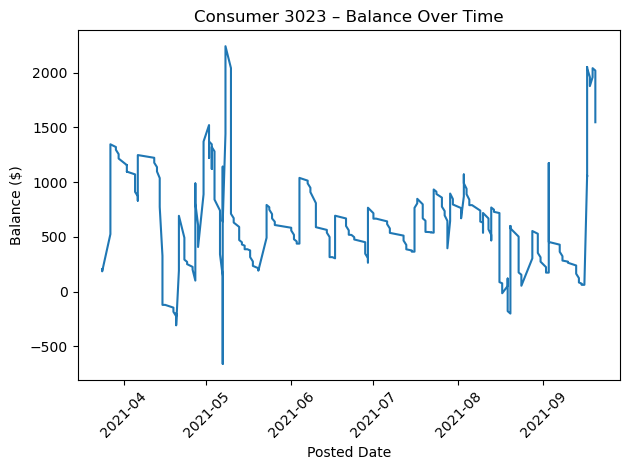

In [121]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(cons_3023["posted_date"], cons_3023["running_balance"])
plt.xlabel("Posted Date")
plt.ylabel("Balance ($)")
plt.title("Consumer 3023 – Balance Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


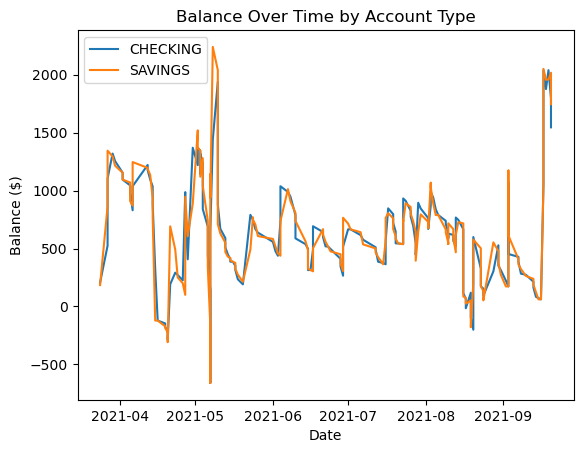

In [122]:
for acct in cons_3023["account_type"].unique():
    df_acct = cons_3023[cons_3023["account_type"] == acct]
    plt.plot(df_acct["posted_date"], df_acct["running_balance"], label=acct)

plt.legend()
plt.xlabel("Date")
plt.ylabel("Balance ($)")
plt.title("Balance Over Time by Account Type")
plt.show()


## week 3: category related attributes

#### i shouldn't have merged all of these together it creates duplicates

looking specifically at categories related to income stability, liquidity stress, and fixed obligations

In [47]:
trxndf = trxndf.merge(cat_map, left_on='category', right_on='category_id', how='left')
trxndf = trxndf.rename(columns={'category_y': 'category_name'}).drop(columns=['category_x', 'category_id'])
full_df = trxndf.merge(acctdf, on='prism_consumer_id', how='left')
full_df = full_df.merge(consdf, on='prism_consumer_id', how='left')
full_df = full_df[[
    'prism_consumer_id', 'prism_account_id', 'prism_transaction_id',
    'account_type', 'balance_date', 'balance',
    'posted_date', 'category_name', 'amount', 'credit_or_debit',
    'evaluation_date', 'credit_score', 'DQ_TARGET'
]]

full_df.head()

,prism_consumer_id,prism_account_id,prism_transaction_id,account_type,balance_date,balance,posted_date,category_name,amount,credit_or_debit,evaluation_date,credit_score,DQ_TARGET
0,3023,0,0,SAVINGS,2021-08-31,90.57,2021-04-16,MISCELLANEOUS,0.05,CREDIT,2021-09-01,699.0,0.0
1,3023,1,0,CHECKING,2021-08-31,225.95,2021-04-16,MISCELLANEOUS,0.05,CREDIT,2021-09-01,699.0,0.0
2,3023,0,1,SAVINGS,2021-08-31,90.57,2021-04-30,LOAN,481.56,CREDIT,2021-09-01,699.0,0.0
3,3023,1,1,CHECKING,2021-08-31,225.95,2021-04-30,LOAN,481.56,CREDIT,2021-09-01,699.0,0.0
4,3023,0,2,SAVINGS,2021-08-31,90.57,2021-05-16,MISCELLANEOUS,0.05,CREDIT,2021-09-01,699.0,0.0


In [48]:
income_categories = {
    'PAYCHECK',
    'DEPOSIT',
    'UNEMPLOYMENT_BENEFITS',
    'OTHER_BENEFITS',
    'PENSION',
    'INVESTMENT_INCOME'
}

In [49]:
income_df = full_df[
    (full_df['category_name'].isin(income_categories)) &
    (full_df['credit_or_debit'] == 'CREDIT') &
    (full_df['amount'] > 0)
].copy()

In [50]:
# category coverage
coverage = (
    income_df
    .groupby('category_name')['prism_consumer_id']
    .nunique()
)

coverage_pct = coverage / full_df['prism_consumer_id'].nunique()
coverage_pct.sort_values(ascending=False)
coverage_pct

category_name
DEPOSIT                  0.803202
INVESTMENT_INCOME        0.261938
OTHER_BENEFITS           0.056445
PAYCHECK                 0.743238
PENSION                  0.053547
UNEMPLOYMENT_BENEFITS    0.043265
Name: prism_consumer_id, dtype: float64

In [51]:
# checking to see if when a transaction is labeled PAYCHECK or DEPOSIT is ths legit under CREDIT

check_cd = (
    full_df
    .groupby(['category_name', 'credit_or_debit'])
    .size()
    .unstack(fill_value=0)
)

check_cd.loc[['PAYCHECK', 'DEPOSIT', 'UNEMPLOYMENT_BENEFITS', 'OTHER_BENEFITS','PENSION','INVESTMENT_INCOME']]



credit_or_debit,CREDIT,DEBIT
category_name,,
PAYCHECK,355211,0
DEPOSIT,235256,0
UNEMPLOYMENT_BENEFITS,14441,0
OTHER_BENEFITS,10673,0
PENSION,12716,0
INVESTMENT_INCOME,58019,0


In [52]:
# Identify duplicated transactions per consumer
dup_txn_counts = (
    income_df
    .groupby(['prism_consumer_id', 'prism_transaction_id'])
    .size()
    .reset_index(name='count')
)

# Keep only transactions that appear more than once (duplicated)
dup_txn_counts = dup_txn_counts[dup_txn_counts['count'] > 1]

# Merge back to get full details of the duplicated transactions
duplicated_txns = income_df.merge(
    dup_txn_counts[['prism_consumer_id', 'prism_transaction_id']],
    on=['prism_consumer_id', 'prism_transaction_id'],
    how='inner'
)

# Optional: sort for easier inspection
duplicated_txns = duplicated_txns.sort_values(
    ['prism_consumer_id', 'prism_transaction_id', 'prism_account_id']
)

# Display first few rows
duplicated_txns

,prism_consumer_id,prism_account_id,prism_transaction_id,account_type,balance_date,balance,posted_date,category_name,amount,credit_or_debit,evaluation_date,credit_score,DQ_TARGET
12441,0,862,136702,SAVINGS,2021-08-31,25.70,2021-09-11,DEPOSIT,500.00,CREDIT,2021-09-01,726.0,0.0
12442,0,863,136702,CHECKING,2021-08-31,294.67,2021-09-11,DEPOSIT,500.00,CREDIT,2021-09-01,726.0,0.0
12443,0,862,136704,SAVINGS,2021-08-31,25.70,2021-03-19,PAYCHECK,1000.22,CREDIT,2021-09-01,726.0,0.0
12444,0,863,136704,CHECKING,2021-08-31,294.67,2021-03-19,PAYCHECK,1000.22,CREDIT,2021-09-01,726.0,0.0
12445,0,862,136706,SAVINGS,2021-08-31,25.70,2021-04-06,PAYCHECK,1075.31,CREDIT,2021-09-01,726.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
136782,9990,9384,1501579,CHECKING,2023-12-08,215.98,2023-11-21,INVESTMENT_INCOME,0.99,CREDIT,2023-12-08,548.0,NaN
136783,9990,9381,1501580,CHECKING,2023-12-08,1392.44,2023-11-30,PAYCHECK,375.00,CREDIT,2023-12-08,548.0,NaN
136784,9990,9382,1501580,SAVINGS,2023-12-08,4406.41,2023-11-30,PAYCHECK,375.00,CREDIT,2023-12-08,548.0,NaN
136785,9990,9383,1501580,SAVINGS,2023-12-08,945.37,2023-11-30,PAYCHECK,375.00,CREDIT,2023-12-08,548.0,NaN


i'm noticing duplicate transactions for the same transaction_id going into both `SAVINGS` and `CHECKING`. i'm going to move forward with `CHECKING` because these categories are considered to be primary income inflows and usually income is deposited into `CHECKING; if i'm understanding the data correct and also included `SAVINGS` then i would be double counting income but idk lol

In [54]:
income_df = full_df[
    (full_df['account_type'] == 'CHECKING') &
    (full_df['category_name'].isin(income_categories))
].copy()

In [55]:
txn_counts = (
    income_df
    .groupby(['prism_consumer_id', 'prism_transaction_id'])
    .size()
    .reset_index(name='count')
)

txn_counts[txn_counts['count'] > 1]



,prism_consumer_id,prism_transaction_id,count
124,10001,5094935,2
125,10001,5094936,2
126,10001,5094937,2
127,10001,5094938,2
128,10001,5094940,2
...,...,...,...
269165,9990,1501576,2
269166,9990,1501577,2
269167,9990,1501578,2
269168,9990,1501579,2


In [37]:
# removing duplicate transaction ids
income_df = income_df.sort_values('posted_date')
income_df = income_df.drop_duplicates(
    subset=['prism_consumer_id', 'prism_transaction_id'],
    keep='first'
)

income_df

,prism_consumer_id,prism_account_id,prism_transaction_id,account_type,balance_date,balance,posted_date,category_name,amount,credit_or_debit,evaluation_date,credit_score,DQ_TARGET
2225809,673,7011,1122034,CHECKING,2020-12-31,203.39,2020-07-09,PAYCHECK,504.17,CREDIT,2021-01-01,716.0,0.0
2225865,673,7011,1122062,CHECKING,2020-12-31,203.39,2020-07-09,PAYCHECK,168.05,CREDIT,2021-01-01,716.0,0.0
1702412,4133,5390,862243,CHECKING,2020-12-31,245.41,2020-07-09,UNEMPLOYMENT_BENEFITS,893.00,CREDIT,2021-01-01,740.0,NaN
212518,3608,716,108728,CHECKING,2020-12-31,17151.80,2020-07-10,PAYCHECK,3083.88,CREDIT,2021-01-01,763.0,0.0
2042503,1228,6406,1034178,CHECKING,2020-12-31,1392.43,2020-07-10,PAYCHECK,1019.92,CREDIT,2021-01-01,734.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3263960,9665,11340,1659741,CHECKING,2024-04-25,14.20,2024-04-18,PAYCHECK,47.14,CREDIT,2023-11-01,494.0,NaN
4720151,8144,15767,2486685,CHECKING,2024-05-06,28.75,2024-04-22,DEPOSIT,1018.44,CREDIT,2023-10-13,534.0,0.0
3263981,9665,11340,1659762,CHECKING,2024-04-25,14.20,2024-04-23,DEPOSIT,40.00,CREDIT,2023-11-01,494.0,NaN
4720152,8144,15767,2486686,CHECKING,2024-05-06,28.75,2024-04-29,PAYCHECK,191.89,CREDIT,2023-10-13,534.0,0.0


#### prepping the data

In [93]:
trxndf.columns


Index(['prism_consumer_id', 'prism_transaction_id', 'category', 'amount',
       'credit_or_debit', 'posted_date'],
      dtype='object')

In [94]:
trxndf = trxndf.merge(
    cat_map,
    left_on='category',
    right_on='category_id',
    how='left'
)

trxndf = trxndf.drop(columns=['category_id'])
trxndf = trxndf.rename(columns={'category_x': 'category_id'})
trxndf = trxndf.rename(columns={'category_y': 'category_name'})


In [84]:
trxndf.head()

,prism_consumer_id,prism_transaction_id,category_x,amount,credit_or_debit,posted_date,category_name
0,3023,0,4,0.05,CREDIT,2021-04-16,MISCELLANEOUS
1,3023,1,12,481.56,CREDIT,2021-04-30,LOAN
2,3023,2,4,0.05,CREDIT,2021-05-16,MISCELLANEOUS
3,3023,3,4,0.07,CREDIT,2021-06-16,MISCELLANEOUS
4,3023,4,4,0.06,CREDIT,2021-07-16,MISCELLANEOUS


In [95]:
income_categories = [
    'PAYCHECK',
    'DEPOSIT',
    'UNEMPLOYMENT_BENEFITS',
    'OTHER_BENEFITS',
    'PENSION',
    'INVESTMENT_INCOME'
]

income_df = trxndf[
    trxndf['category_name'].isin(income_categories)
].copy()

In [96]:
income_df

,prism_consumer_id,prism_transaction_id,category_id,amount,credit_or_debit,posted_date,category_name
10,3023,10,2,208.05,CREDIT,2021-04-06,DEPOSIT
17,3023,17,3,900.00,CREDIT,2021-05-07,PAYCHECK
19,3023,19,2,800.00,CREDIT,2021-05-08,DEPOSIT
20,3023,20,2,300.00,CREDIT,2021-05-23,DEPOSIT
21,3023,21,3,300.00,CREDIT,2021-06-04,PAYCHECK
...,...,...,...,...,...,...,...
6405224,10533,6405224,8,1682.00,CREDIT,2022-01-31,OTHER_BENEFITS
6405228,10533,6405228,8,841.00,CREDIT,2022-02-27,OTHER_BENEFITS
6405229,10533,6405229,8,841.00,CREDIT,2022-02-27,OTHER_BENEFITS
6405232,10533,6405232,8,841.00,CREDIT,2022-03-30,OTHER_BENEFITS


In [98]:
income_df['prism_transaction_id'].duplicated().sum()


0

In [106]:
income_df['posted_date'] = pd.to_datetime(income_df['posted_date'])


### 1. income stability & support (categories: `PAYCHECK/DEPOSIT`, `UNEMPLOYMENT_BENEFITS`, `OTHER_BENEFITS`, `PENSION`, `INVESTMENT_INCOME`)

In [107]:
income_core = (
    income_df
    .groupby('prism_consumer_id')
    .agg(
        total_income=('amount', 'sum'),
        avg_income=('amount', 'mean'),
        median_income=('amount', 'median'),
        max_income=('amount', 'max'),
        income_txn_count=('amount', 'count')
    )
    .reset_index()
)


In [136]:
category_counts = (
    income_df
    .groupby(['prism_consumer_id', 'category_name'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

category_ratios = category_counts.merge(
    income_core[['prism_consumer_id', 'income_txn_count']],
    on='prism_consumer_id',
    how='left'
)

for cat in income_categories:
    if cat in category_ratios.columns:
        category_ratios[f'{cat.lower()}_ratio'] = (
            category_ratios[cat] / category_ratios['income_txn_count']
        )

category_ratios = category_ratios[
    ['prism_consumer_id'] +
    [c for c in category_ratios.columns if c.endswith('_ratio')]
]


In [137]:
income_vol = (
    income_df
    .groupby('prism_consumer_id')
    .agg(
        income_std=('amount', 'std')
    )
    .reset_index()
)

income_vol['income_cv'] = income_vol['income_std'] / (
    income_core.set_index('prism_consumer_id')['avg_income'].values
)


In [138]:
paycheck_df = income_df[income_df['category_name'] == 'PAYCHECK']

paycheck_features = (
    paycheck_df
    .groupby('prism_consumer_id')
    .agg(
        paycheck_count=('amount', 'count'),
        avg_paycheck=('amount', 'mean'),
        std_paycheck=('amount', 'std'),
        max_paycheck=('amount', 'max')
    )
    .reset_index()
)
paycheck_features['paycheck_cv'] = (
    paycheck_features['std_paycheck'] /
    paycheck_features['avg_paycheck']
)


In [139]:
income_time = (
    income_df
    .groupby('prism_consumer_id')
    .agg(
        first_income_date=('posted_date', 'min'),
        last_income_date=('posted_date', 'max')
    )
    .reset_index()
)

income_time['income_span_days'] = (
    income_time['last_income_date'] - income_time['first_income_date']
).dt.days


In [140]:
latest_date = income_df['posted_date'].max()

recent_income = (
    income_df[income_df['posted_date'] >= latest_date - pd.Timedelta(days=90)]
    .groupby('prism_consumer_id')
    .agg(
        income_last_90d=('amount', 'sum'),
        txn_last_90d=('amount', 'count')
    )
    .reset_index()
)


In [143]:
features_df = (
    consdf
    .merge(income_core, on='prism_consumer_id', how='left')
    .merge(income_vol, on='prism_consumer_id', how='left')
    .merge(paycheck_features, on='prism_consumer_id', how='left')
    .merge(category_ratios, on='prism_consumer_id', how='left')
    .merge(
        income_time[['prism_consumer_id', 'income_span_days']],
        on='prism_consumer_id',
        how='left'
    )
    .merge(recent_income, on='prism_consumer_id', how='left')
)

features_df = features_df.fillna(0)



In [144]:
features_df

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET,total_income,avg_income,median_income,max_income,income_txn_count,income_std,...,paycheck_cv,paycheck_ratio,deposit_ratio,unemployment_benefits_ratio,other_benefits_ratio,pension_ratio,investment_income_ratio,income_span_days,income_last_90d,txn_last_90d
0,0,2021-09-01,726.0,0.0,9320.56,932.056000,1057.905,1250.30,10.0,328.037055,...,0.314710,0.900000,0.100000,0.000,0.000000,0.0,0.000000,176.0,0.0,0.0
1,1,2021-07-01,626.0,0.0,13411.59,838.224375,864.355,1031.08,16.0,232.350425,...,0.289665,0.875000,0.125000,0.000,0.000000,0.0,0.000000,168.0,0.0,0.0
2,2,2021-05-01,680.0,0.0,1100.00,550.000000,550.000,1000.00,2.0,636.396103,...,0.000000,0.000000,1.000000,0.000,0.000000,0.0,0.000000,92.0,0.0,0.0
3,3,2021-03-01,734.0,0.0,10777.81,1347.226250,999.785,4398.00,8.0,1291.529922,...,0.000449,0.375000,0.250000,0.375,0.000000,0.0,0.000000,166.0,0.0,0.0
4,4,2021-10-01,676.0,0.0,12074.44,603.722000,760.000,1060.00,20.0,307.163439,...,0.000000,0.000000,0.150000,0.850,0.000000,0.0,0.000000,329.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,2022-03-08,655.0,0.0,9295.34,546.784706,664.540,1321.53,17.0,432.795666,...,0.879764,0.823529,0.176471,0.000,0.000000,0.0,0.000000,84.0,0.0,0.0
14996,14996,2022-01-15,625.0,0.0,31536.58,525.609667,347.010,2480.00,60.0,559.338703,...,0.663994,0.350000,0.466667,0.050,0.000000,0.0,0.133333,245.0,0.0,0.0
14997,14997,2022-01-31,688.0,0.0,23141.97,701.271818,1167.030,1734.41,33.0,602.375733,...,0.154088,0.575758,0.424242,0.000,0.000000,0.0,0.000000,238.0,0.0,0.0
14998,14998,2022-03-08,722.0,0.0,54783.80,493.547748,300.000,3200.00,111.0,429.223879,...,0.707054,0.819820,0.171171,0.000,0.009009,0.0,0.000000,227.0,0.0,0.0


#### model + auc

In [145]:
model_df = consdf.merge(
    features_df,
    on='prism_consumer_id',
    how='left'
)

In [146]:
model_df.columns

Index(['prism_consumer_id', 'evaluation_date_x', 'credit_score_x',
       'DQ_TARGET_x', 'evaluation_date_y', 'credit_score_y', 'DQ_TARGET_y',
       'total_income', 'avg_income', 'median_income', 'max_income',
       'income_txn_count', 'income_std', 'income_cv', 'paycheck_count',
       'avg_paycheck', 'std_paycheck', 'max_paycheck', 'paycheck_cv',
       'paycheck_ratio', 'deposit_ratio', 'unemployment_benefits_ratio',
       'other_benefits_ratio', 'pension_ratio', 'investment_income_ratio',
       'income_span_days', 'income_last_90d', 'txn_last_90d'],
      dtype='object')

In [147]:
model_df = model_df.rename(columns={
    'DQ_TARGET_x': 'DQ_TARGET',
    'credit_score_x': 'credit_score',
    'evaluation_date_x': 'evaluation_date'
})
model_df = model_df.drop(columns=[
    'DQ_TARGET_y',
    'credit_score_y',
    'evaluation_date_y'
])

In [149]:
model_df = model_df[model_df['DQ_TARGET'].notna()].copy()

In [150]:
model_df['DQ_TARGET'].value_counts(normalize=True)


DQ_TARGET
0.0    0.916167
1.0    0.083833
Name: proportion, dtype: float64

In [151]:
y = model_df['DQ_TARGET'].astype(int)

In [152]:
drop_cols = [
    'prism_consumer_id',
    'DQ_TARGET',
    'evaluation_date',
    'credit_score'
]

X = model_df.drop(columns=drop_cols)
X = X.fillna(0)


In [153]:
X.columns

Index(['total_income', 'avg_income', 'median_income', 'max_income',
       'income_txn_count', 'income_std', 'income_cv', 'paycheck_count',
       'avg_paycheck', 'std_paycheck', 'max_paycheck', 'paycheck_cv',
       'paycheck_ratio', 'deposit_ratio', 'unemployment_benefits_ratio',
       'other_benefits_ratio', 'pension_ratio', 'investment_income_ratio',
       'income_span_days', 'income_last_90d', 'txn_last_90d'],
      dtype='object')

In [154]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)


In [155]:
model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced'
)

model.fit(X_train, y_train)


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=1000)

In [156]:
from sklearn.metrics import roc_auc_score

y_pred_proba = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)

print("ROC-AUC:", auc)


ROC-AUC: 0.6539704978734855


checking the spread

In [157]:
y = model_df['DQ_TARGET'].astype(int)

In [158]:
feature_aucs = []

for col in X.columns:
    # Skip constant features
    if X[col].nunique() <= 1:
        continue

    auc = roc_auc_score(y, X[col])
    
    # If AUC < 0.5, flip interpretation
    if auc < 0.5:
        auc = 1 - auc

    feature_aucs.append({
        'feature': col,
        'auc': auc
    })

auc_df = pd.DataFrame(feature_aucs).sort_values('auc', ascending=False)
auc_df


,feature,auc
18,income_span_days,0.637519
0,total_income,0.595979
4,income_txn_count,0.567905
1,avg_income,0.565877
7,paycheck_count,0.558794
3,max_income,0.557921
2,median_income,0.555899
8,avg_paycheck,0.549818
10,max_paycheck,0.548111
9,std_paycheck,0.534798


### 2. fixed obligations & debt burden (`RENT`, `MORTGAGE`, `AUTO_LOAN`, `DEBT`, `CREDIT_CARD_PAYMENT`, `BNPL`, `RTO_LTO`)

In [166]:
full_df[full_df['prism_consumer_id'] == '0']

,prism_consumer_id,prism_transaction_id,category_id,amount,credit_or_debit,posted_date,evaluation_date,credit_score,DQ_TARGET,prism_account_id,account_type,balance_date,balance,net_flow,avg_net_flow,category_name
213671,0,136696,4,0.09,CREDIT,2021-03-19,2021-09-01,726.0,0.0,862,SAVINGS,2021-08-31,25.70,-1043.18,-174.834637,MISCELLANEOUS
213672,0,136696,4,0.09,CREDIT,2021-03-19,2021-09-01,726.0,0.0,863,CHECKING,2021-08-31,294.67,-1043.18,-174.834637,MISCELLANEOUS
213673,0,136697,4,0.05,CREDIT,2021-04-16,2021-09-01,726.0,0.0,862,SAVINGS,2021-08-31,25.70,-1043.18,-174.834637,MISCELLANEOUS
213674,0,136697,4,0.05,CREDIT,2021-04-16,2021-09-01,726.0,0.0,863,CHECKING,2021-08-31,294.67,-1043.18,-174.834637,MISCELLANEOUS
213675,0,136698,4,0.06,CREDIT,2021-05-21,2021-09-01,726.0,0.0,862,SAVINGS,2021-08-31,25.70,-1043.18,-174.834637,MISCELLANEOUS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214482,0,137101,14,27.14,DEBIT,2021-09-10,2021-09-01,726.0,0.0,863,CHECKING,2021-08-31,294.67,-1043.18,-174.834637,FOOD_AND_BEVERAGES
214483,0,137102,1,330.00,DEBIT,2021-09-11,2021-09-01,726.0,0.0,862,SAVINGS,2021-08-31,25.70,-1043.18,-174.834637,EXTERNAL_TRANSFER
214484,0,137102,1,330.00,DEBIT,2021-09-11,2021-09-01,726.0,0.0,863,CHECKING,2021-08-31,294.67,-1043.18,-174.834637,EXTERNAL_TRANSFER
214485,0,137103,19,500.00,DEBIT,2021-09-11,2021-09-01,726.0,0.0,862,SAVINGS,2021-08-31,25.70,-1043.18,-174.834637,ATM_CASH
